#### Load base required libraries from msmbuilder and python

In [2]:
#msmbuilder imports 
from msmbuilder.dataset import dataset
from msmbuilder.featurizer import AlphaAngleFeaturizer
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import ContinuousTimeMSM
from msmbuilder.utils import verbosedump,verboseload

#other imports
import os,glob
import numpy as np
import mdtraj as md
import pandas as pd 
import pickle

#prettier plots
import seaborn as sns
%pylab inline
matplotlib.rcParams['xtick.labelsize'] = 14 
matplotlib.rcParams['ytick.labelsize'] = 14 
matplotlib.rcParams['font.family'] = "sans-serif"

Populating the interactive namespace from numpy and matplotlib


#### Initialization
Specify the folder where the trajectories are stored and create a dataset object

In [4]:
trajectory_folder_path=os.path.abspath("../trajectories/")
ds = dataset(trajectory_folder_path+"/*.lh5")

#get some stats about the dataset
print("Number of trajectories is %d"%len(ds))

Number of trajectories is 21588


#### Featurize trajectories
First we extract alpha angle data from each frame in the trajectory. We use the 'sincos' option to return the sine and cosine of each alpha angle to account for periodicity.

In [23]:
#define our featurizer
feat = AlphaAngleFeaturizer(sincos=True)

#transform the data with the featurizer
ds_alpha=ds.fit_transform_with(feat, "alpha_angle/",fmt='dir-npy')

#we can load the features using
ds_alpha = dataset("./alpha_angle/")

#see how many trajectories were retained during featurization
print(len(ds_alpha),len(ds))

21587 21588


#### Create tICA model
Next we further reduce the dimensionality of our trajectory. The number of tICA components is the number of slow processes that we will retain. Each of the processes will be a linear combination of the alpha angle features created in the previous step.

In [88]:
#define our tica model
tica_mdl = tICA(lag_time=500,n_components=10)

#transform the dataset with tica
tica_features = ds_alpha.fit_transform_with(tica_mdl, out_ds = 'reg_ticas_500lt_10tics//')

#load the features
tica_features = dataset("./reg_ticas_500lt_10tics/")

#for each feature from our alpha angle featurization we now have 10 tICs
tica_features[0].shape

(156, 10)

In [89]:
#lets dump the tica mdl for future use
verbosedump(tica_mdl,"tica_mdl.pkl")

Saving "tica_mdl.pkl"... (<class 'msmbuilder.decomposition.tica.tICA'>)


#### Clustering into microstates

In [90]:
#cluster the tica data into microstates
kmeans_mdl = MiniBatchKMeans(200)
assignments = tica_features.fit_transform_with(kmeans_mdl,out_ds='assignments/')
assignments = dataset("assignments/")

In [92]:
#lets dump the kmeans mdl for future use
verbosedump(kmeans_mdl,"kmeans_mdl.pkl")

Saving "kmeans_mdl.pkl"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)


#### Construct the MSM

In [97]:
msm_mdl = ContinuousTimeMSM(lag_time=400,ergodic_cutoff=1/400)
assignments.fit_with(msm_mdl)

ContinuousTimeMSM(ergodic_cutoff=0.0025, guess='log', lag_time=400,
         n_timescales=None, sliding_window=True, verbose=False)

In [98]:
#how much of the data was retained during model creation?
msm_mdl.percent_retained_

98.908709338929697

In [100]:
#now we are going to dump our continuous msm model into a .pkl
f=open("msm_mdl.pkl",'wb')
pickle.dump({
            k: cmsm_mdl.__dict__[k]
            for k in [
                'lag_time',
                'n_timescales',
                'ergodic_cutoff',
                'verbose',
                'sliding_window',
                'guess',
                'theta_',
                'ratemat_',
                'transmat_',
                'countsmat_',
                'n_states_',
                'mapping_',
                'populations_',
                'information_',
                'loglikelihoods_',
                'timescales_',
                'eigenvalues_',
                'left_eigenvectors_',
                'right_eigenvectors_',
                'percent_retained_',
            ]
        }, f)
f.close()

#### Understanding the features

In [3]:
#load our models
tica_mdl = verboseload("tica_mdl.pkl")
tica_data=dataset("./reg_ticas_500lt_10tics/")

loading "tica_mdl.pkl"...


In [7]:
#choose a frame so the residues can be loaded
pdb_top = md.load("../trajectories/trj0.lh5")[0]

#lets get a decription of the features
df = pd.DataFrame(feat.describe_features(pdb_top))

df.head()

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[3, 27, 42, 63]",N/A,AlphaAngle,cos,"[0, 1, 2, 3]","[TRP, GLU, PRO, ILE]","[0, 1, 2, 3]"
1,"[27, 42, 63, 75]",N/A,AlphaAngle,cos,"[1, 2, 3, 4]","[ARG, GLU, PRO, ILE]","[1, 2, 3, 4]"
2,"[42, 63, 75, 99]",N/A,AlphaAngle,cos,"[2, 3, 4, 5]","[ARG, GLU, PRO, ILE]","[2, 3, 4, 5]"
3,"[63, 75, 99, 114]",N/A,AlphaAngle,cos,"[3, 4, 5, 6]","[ARG, GLU, PRO, SER]","[3, 4, 5, 6]"
4,"[75, 99, 114, 125]",N/A,AlphaAngle,cos,"[4, 5, 6, 7]","[LEU, ARG, GLU, SER]","[4, 5, 6, 7]"


In [13]:
feature_index=0
inds=abs(tica_mdl.components_[feature_index,:])>0.15
#what are the important residues?
df.iloc[inds]

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
408,"[2387, 2411, 2430, 2449]",N/A,AlphaAngle,sin,"[152, 149, 150, 151]","[LEU, ARG, GLU, ILE]","[152, 149, 150, 151]"
422,"[2608, 2630, 2652, 2664]",N/A,AlphaAngle,sin,"[163, 164, 165, 166]","[LYS, PHE, PRO, ILE]","[163, 164, 165, 166]"


#### Plotting the first and second tICS

In [15]:
txx=np.concatenate(tica_data)

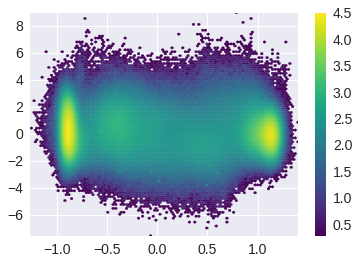

In [16]:
hexbin(txx[:,0],txx[:,1],bins='log',mincnt=1,cmap='viridis')
colorbar()

#### For further analysis please see the src_kinase_msmb_paper_mdl_analysis notebook